In [9]:
import os
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Activation
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [10]:
directory = r'C:\Users\VIRUS\Desktop\Project_ML\IITKGP-SEHSC'

In [11]:

# Function to traverse directory and find .wav files
def find_wav_files(directory):
    wav_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.wav'):
                filepath = os.path.join(root, file)
                split_name = file.split('.')
                split_name = split_name[2].split('-')
                if len(split_name) > 0:
                    file_name = split_name[0]
                else:
                    # If the file name does not have enough parts, keep the whole name
                    file_name = file
                wav_files.append((filepath, file_name))
    return wav_files


# Find .wav files
wav_files = find_wav_files(directory)

# Create a DataFrame with the file paths and modified file names
sehsc_df = pd.DataFrame(wav_files, columns=['Path', 'Emotions'])

# Print the count of total .wav files
print(f"Total number of .wav files: {len(sehsc_df)}")

# Display the DataFrame
print(sehsc_df)


Total number of .wav files: 12000
                                                    Path  Emotions
0      C:\Users\VIRUS\Desktop\Project_ML\IITKGP-SEHSC...     anger
1      C:\Users\VIRUS\Desktop\Project_ML\IITKGP-SEHSC...     anger
2      C:\Users\VIRUS\Desktop\Project_ML\IITKGP-SEHSC...     anger
3      C:\Users\VIRUS\Desktop\Project_ML\IITKGP-SEHSC...     anger
4      C:\Users\VIRUS\Desktop\Project_ML\IITKGP-SEHSC...     anger
...                                                  ...       ...
11995  C:\Users\VIRUS\Desktop\Project_ML\IITKGP-SEHSC...  surprise
11996  C:\Users\VIRUS\Desktop\Project_ML\IITKGP-SEHSC...  surprise
11997  C:\Users\VIRUS\Desktop\Project_ML\IITKGP-SEHSC...  surprise
11998  C:\Users\VIRUS\Desktop\Project_ML\IITKGP-SEHSC...  surprise
11999  C:\Users\VIRUS\Desktop\Project_ML\IITKGP-SEHSC...  surprise

[12000 rows x 2 columns]


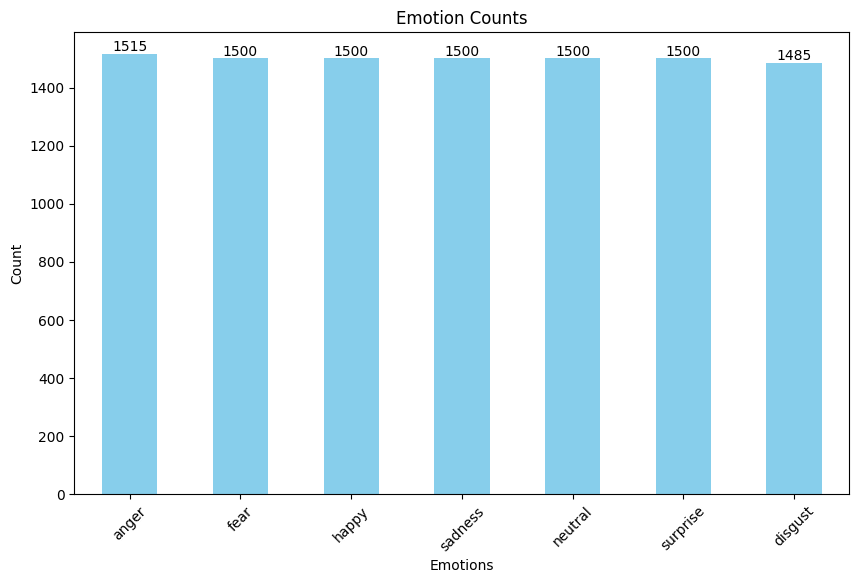

In [12]:
# dropping the sarcastic Emotion
sehsc_df = sehsc_df[sehsc_df['Emotions'] != 'sarcastic']


# Count the number of unique emotions
emotion_counts = sehsc_df['Emotions'].value_counts()

plt.figure(figsize=(10, 6))
ax = emotion_counts.plot(kind='bar', color='skyblue')

# Add counts on top of each bar
for i in ax.containers:
    ax.bar_label(i, label_type="edge")

plt.title('Emotion Counts')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()



In [13]:

# Feature Extraction Function

def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_best')

    # Extract MFCC features
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    # Extract Chroma Features
    chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate, n_chroma=12)
    chroma_scaled_features = np.mean(chroma.T, axis=0)

    # Extract Mel Spectrogram Features
    mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    mel_scaled_features = np.mean(mel.T, axis=0)

    # Concatenate all features into a single array
    features = np.hstack((mfccs_scaled_features,chroma_scaled_features, mel_scaled_features))

    return features

In [14]:
from tqdm import tqdm
extracted_features = []
for path in tqdm(sehsc_df['Path']):
    feature= features_extractor(path)
    extracted_features.append(feature)

100%|██████████| 10500/10500 [25:12<00:00,  6.94it/s] 


In [16]:
# Extract labels from the DataFrame
label = sehsc_df['Emotions'].to_numpy()

# Initialize the LabelEncoder
labelencoder = LabelEncoder()

# Fit the encoder and transform the labels
encoded_labels = labelencoder.fit_transform(label)

# Convert to categorical (one-hot encoding)
labels = to_categorical(encoded_labels)

# Create the dictionary for mapping original labels to their encoded values
label_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))

# Display the dictionary
print("Encoded Labels Dictionary:", label_mapping)


Encoded Labels Dictionary: {'anger': np.int64(0), 'disgust': np.int64(1), 'fear': np.int64(2), 'happy': np.int64(3), 'neutral': np.int64(4), 'sadness': np.int64(5), 'surprise': np.int64(6)}


In [17]:
features = np.array(extracted_features)
labels = np.array(labels)

In [18]:
features.shape, labels.shape

((10500, 180), (10500, 7))

In [19]:
# To save features and labels of the dataset
np.save('features_sehsc.npy',extracted_features)
np.save('labels_sehsc.npy',labels)


In [ ]:
# # Loading THe features and Labels
# features = np.load('features_sehsc.npy')
# labels = np.load('labels_sehsc.npy')
# features.shape,labels.shape

In [20]:
### Train Test Split Training 70% testing 30%
X_train,X_test,y_train,y_test=train_test_split(features,labels,test_size=0.3,random_state=42)

### Train Test Split Testing 50% testing 50%
X_test,X_val,y_test,y_val=train_test_split(X_test,y_test,test_size=0.5,random_state=42)

# Total Distribution = Train=70%, Test=15 % , Validation=15 %

In [21]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape,  y_val.shape

((7350, 180), (7350, 7), (1575, 180), (1575, 7), (1575, 180), (1575, 7))

In [22]:
# No of classes
input_shape = (X_train.shape[1], 1)
num_classes =  (y_train.shape[1])

In [23]:


# Define the model
model = Sequential()

# First convolutional layer with stride 1
model.add(Conv1D(filters=512, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Second convolutional layer with stride 1
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Third convolutional layer with stride 1
model.add(Conv1D(filters=256, kernel_size=3,activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# Fourth convolutional layer with stride 1
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# Flatten the output and add dense layers
model.add(Flatten())

# Dense Layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))

# Output layer
model.add(Dense(num_classes, activation='softmax'))


# Set the learning rate
learning_rate = 0.0005

# Compile the model with the Adam optimizer and specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


c:\Users\VIRUS\Desktop\Project_ML\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 178, 512)       │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 89, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 89, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 87, 256)        │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 43, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 43, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 18, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,019,783 (3.89 MB)

 Trainable params: 1,019,783 (3.89 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)


In [25]:
# Trianing my model
num_epochs = 100
num_batch_size = 64

history = model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_val, y_val),callbacks=[early_stopping, reduce_lr])

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 0.2057 - loss: 1.9408 - val_accuracy: 0.2984 - val_loss: 1.7211 - learning_rate: 5.0000e-04
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 0.2788 - loss: 1.7468 - val_accuracy: 0.3816 - val_loss: 1.6194 - learning_rate: 5.0000e-04
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.3395 - loss: 1.6319 - val_accuracy: 0.3956 - val_loss: 1.5225 - learning_rate: 5.0000e-04
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step - accuracy: 0.3672 - loss: 1.5531 - val_accuracy: 0.4330 - val_loss: 1.4442 - learning_rate: 5.0000e-04
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 0.4219 - loss: 1.4793 - val_accuracy: 0.4743 - val_loss: 1.3483 - learning_rate: 5.0000e-04
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 0.4677 - loss: 1.3778 - val_accuracy: 0.4679 - val_loss: 1.3622 - learning_rate: 5.0000e-04
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━

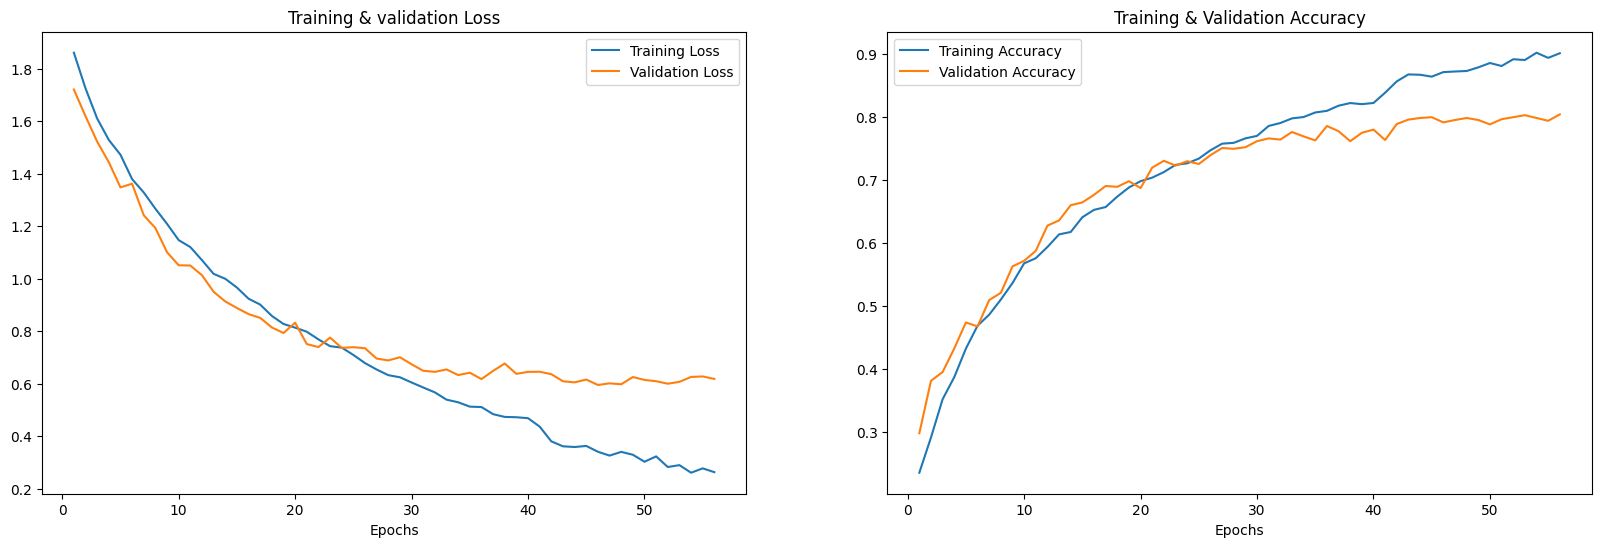

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7894 - loss: 0.6322
Accuracy of our model on test data: 78.41269969940186 %


In [26]:

# Extracting accuracy and loss values from the history object
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

# Extracting the number of epochs from the history object
epochs = range(1, len(train_acc) + 1)

# Plotting the training and testing loss
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 6)

ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Validation Loss')
ax[0].set_title('Training & validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

# Plotting the training and testing accuracy
ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.show()

# Printing the accuracy of the model on test data
print("Accuracy of our model on test data:",model.evaluate(X_test, y_test)[1] * 100, "%")

In [27]:
y_pred = np.argmax(model.predict(X_test), axis=1)
real_labels = np.argmax(y_test, axis=1)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [28]:
# Calculate and print the accuracy score as a percentage
accuracy = accuracy_score(real_labels, y_pred) * 100
print(f"Accuracy Score: {accuracy:.2f}%")

# Print the classification report
print("Classification Report:")
print(classification_report(real_labels, y_pred, target_names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']))


Accuracy Score: 78.41%
Classification Report:
              precision    recall  f1-score   support

       angry       0.79      0.85      0.82       221
     disgust       0.75      0.73      0.74       242
        fear       0.78      0.75      0.76       208
       happy       0.81      0.73      0.77       239
     neutral       0.79      0.85      0.82       209
         sad       0.76      0.78      0.77       237
    surprise       0.80      0.81      0.81       219

    accuracy                           0.78      1575
   macro avg       0.78      0.79      0.78      1575
weighted avg       0.78      0.78      0.78      1575



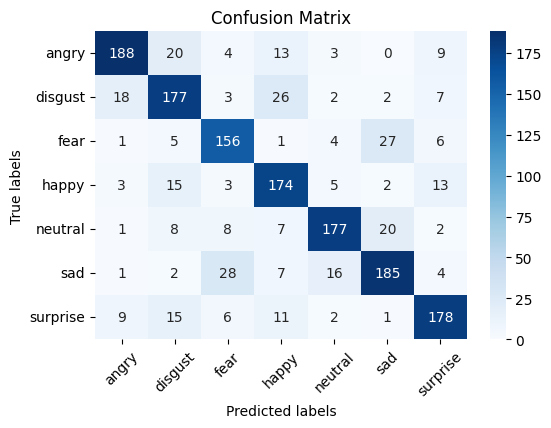

In [29]:
cm = confusion_matrix(y_pred, real_labels)
class_labels = ['angry', 'disgust' ,'fear', 'happy', 'neutral', 'sad','surprise']

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.xticks(rotation=45)
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [30]:
model.save('speech.keras')